# Pentad Generation Test

This notebook demonstrates how to generate a grid of SABAP pentads covering a specific country (or any polygon).

In [2]:
import sys
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import json

# Add the parent directory to sys.path to import the package
sys.path.append(os.path.abspath('..'))

from eBird2ABAP.pentad import *

## Load Country Data

We use a public GeoJSON file to get the boundary of a country. Let's pick Kenya as an example.

<Axes: >

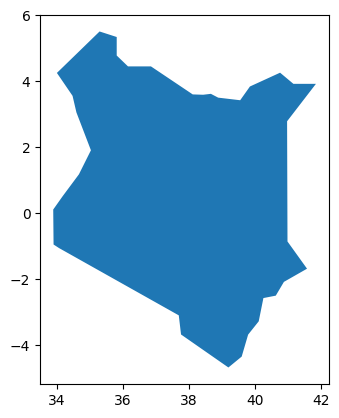

In [3]:
url = 'https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/world-countries.json'
world = gpd.read_file(url)
country_name = "Kenya"
country = world[world.name == country_name]

# Ensure we have a single geometry
country_geom = country.geometry.iloc[0]

country.plot()

## Generate Pentads

Now we generate the pentads that intersect with the country's boundary.

In [4]:
# Generate pentads (returns a GeoJSON string by default)
pentads_geojson = generate_pentad_grid(country_geom, return_geojson=True)

# Convert back to GeoDataFrame for plotting
pentads_gdf = gpd.GeoDataFrame.from_features(json.loads(pentads_geojson)['features'])
pentads_gdf.set_crs(epsg=4326, inplace=True)

print(f"Generated {len(pentads_gdf)} pentads for {country_name}.")
pentads_gdf.head()

Generated 7158 pentads for Kenya.


,geometry,pentad
0,"POLYGON ((39.25 -4.75, 39.25 -4.66667, 39.1666...",0440_3910
1,"POLYGON ((39.08333 -4.66667, 39.08333 -4.58333...",0435_3900
2,"POLYGON ((39.16667 -4.66667, 39.16667 -4.58333...",0435_3905
3,"POLYGON ((39.25 -4.66667, 39.25 -4.58333, 39.1...",0435_3910
4,"POLYGON ((39.33333 -4.66667, 39.33333 -4.58333...",0435_3915


## Visualize

Plot the pentads on top of the country map.

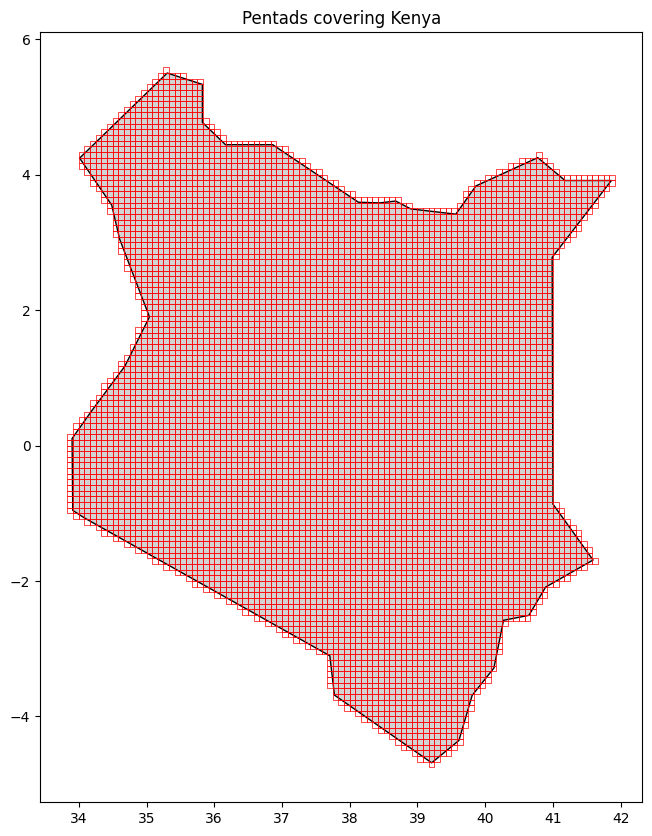

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
country.plot(ax=ax, color='lightgray', edgecolor='black')
pentads_gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=0.5)
plt.title(f"Pentads covering {country_name}")
plt.show()

## Export Kenya Pentads

Save the generated pentads to a GeoJSON file.

In [7]:
output_file = "../data/kenya_pentads.geojson"
with open(output_file, "w") as f:
    f.write(pentads_geojson)
print(f"Exported to {output_file}")

Exported to ../data/kenya_pentads.geojson


## Africa Example

Now let's generate pentads for the entire African continent. We will approximate Africa by selecting countries within its bounding box from the world dataset.

Generated Africa geometry.


/var/folders/cm/dh8lmmxn3b5bcb2_gbz16ycm0000gn/T/ipykernel_4157/2273205448.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  (africa_countries.geometry.centroid.x > -20) &
/var/folders/cm/dh8lmmxn3b5bcb2_gbz16ycm0000gn/T/ipykernel_4157/2273205448.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  (africa_countries.geometry.centroid.x < 55) &
/var/folders/cm/dh8lmmxn3b5bcb2_gbz16ycm0000gn/T/ipykernel_4157/2273205448.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  (africa_countries.geometry.centroid.y > -35) &
/var/folders/cm/dh8lmmxn3b5bcb2_gbz16ycm0000gn/T/ipykern

<Axes: >

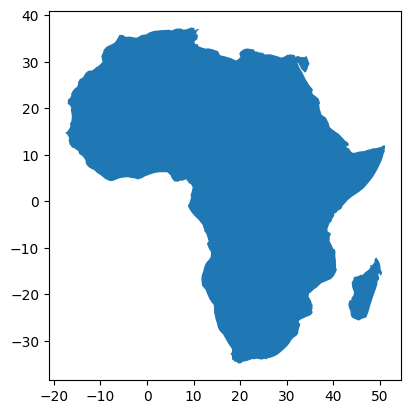

In [9]:
# Define a rough bounding box for Africa
# Longitude: -20 to 55, Latitude: -35 to 40
africa_countries = world.cx[-20:55, -35:40]

# Filter further by checking if centroid is actually in the box (cx is intersection)
africa_countries = africa_countries[
    (africa_countries.geometry.centroid.x > -20) &
    (africa_countries.geometry.centroid.x < 55) &
    (africa_countries.geometry.centroid.y > -35) &
    (africa_countries.geometry.centroid.y < 40)
]

# Explicitly remove non-African countries that fall into the bounding box
non_african_countries = [
    'Portugal', 'Greece', 'Turkey', 'Cyprus', 'Northern Cyprus', 
    'Israel', 'West Bank', 'Lebanon', 'Syria', 'Jordan', 
    'Iraq', 'Kuwait', 'Saudi Arabia', 'Yemen', 'Qatar', 
    'United Arab Emirates', 'Iran'
]
africa_countries = africa_countries[~africa_countries['name'].isin(non_african_countries)]

# Dissolve to get a single polygon for the continent
africa_geom = africa_countries.dissolve().geometry.iloc[0]

print("Generated Africa geometry.")
gpd.GeoSeries([africa_geom]).plot()

In [10]:
print("Generating pentads for Africa... this might take a while.")
africa_pentads_geojson = generate_pentad_grid(africa_geom, return_geojson=True)

africa_pentads_gdf = gpd.GeoDataFrame.from_features(json.loads(africa_pentads_geojson)['features'])
africa_pentads_gdf.set_crs(epsg=4326, inplace=True)

print(f"Generated {len(africa_pentads_gdf)} pentads for Africa.")

Generating pentads for Africa... this might take a while.
Generated 371244 pentads for Africa.


In [13]:
# Export Africa Pentads
output_file_africa = "../data/africa_pentads.geojson"
with open(output_file_africa, "w") as f:
    f.write(africa_pentads_geojson)
print(f"Exported to {output_file_africa}")

Exported to ../data/africa_pentads.geojson


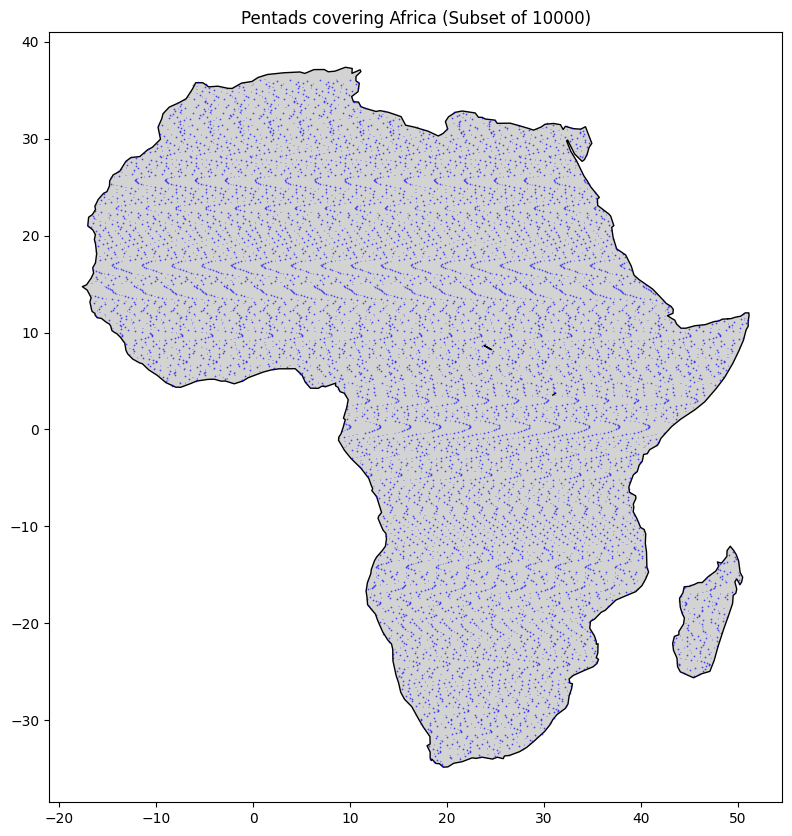

In [17]:
# Visualize a subset (plotting all might be slow)
fig, ax = plt.subplots(figsize=(10, 10))
gpd.GeoSeries([africa_geom]).plot(ax=ax, color='lightgray', edgecolor='black')

# Plotting 5000 pentads sampled uniformly from the sequence
total_pentads = len(africa_pentads_gdf)
num_samples = 10000
step = max(1, total_pentads // num_samples)
subset = africa_pentads_gdf.iloc[::step].iloc[:num_samples]

subset.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=0.3)
plt.title(f"Pentads covering Africa (Subset of {len(subset)})")
plt.show()